In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [2]:
train_data = TabularDataset('Train.csv')
test_data = TabularDataset('Test.csv')


train_data.head()

label = 'label'
train_data[label].describe()

count    6000.000000
mean        0.500000
std         0.500042
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [3]:
predictor = TabularPredictor(label=label).fit(train_data)

No path specified. Models will be saved in: "AutogluonModels\ag-20240213_095817"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240213_095817"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
Memory Avail:      

In [4]:
predictor = TabularPredictor(label=label).load(path="./AutogluonModels/ag-20231215_150640")

No path specified. Models will be saved in: "AutogluonModels\ag-20240213_095845"


In [5]:
y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [6]:
predictor.evaluate(test_data, silent=True)

{'accuracy': 0.97325,
 'balanced_accuracy': 0.97325,
 'mcc': 0.9465341941654075,
 'roc_auc': 0.996737,
 'f1': 0.9733632063729151,
 'precision': 0.969261279127417,
 'recall': 0.9775}

In [7]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.97325,0.983333,accuracy,0.076997,0.018068,10.232093,0.007000,0.001055,0.569103,2,True,14
1,LightGBMXT,0.97275,0.978333,accuracy,0.029999,0.010000,1.898996,0.029999,0.010000,1.898996,1,True,3
2,NeuralNetFastAI,0.97100,0.978333,accuracy,1.248926,0.018003,5.882201,1.248926,0.018003,5.882201,1,True,10
3,NeuralNetTorch,0.96800,0.978333,accuracy,0.027001,0.005000,6.503999,0.027001,0.005000,6.503999,1,True,12
4,CatBoost,0.96700,0.980000,accuracy,0.012000,0.005013,2.189992,0.012000,0.005013,2.189992,1,True,7
5,LightGBM,0.96700,0.970000,accuracy,0.049001,0.010001,1.836509,0.049001,0.010001,1.836509,1,True,4
6,XGBoost,0.96625,0.971667,accuracy,0.030996,0.006999,0.969000,0.030996,0.006999,0.969000,1,True,11
7,LightGBMLarge,0.96425,0.965000,accuracy,0.102000,0.010000,2.042997,0.102000,0.010000,2.042997,1,True,13
8,KNeighborsDist,0.96175,0.953333,accuracy,0.077999,0.018999,0.025001,0.077999,0.018999,0.025001,1,True,2
9,KNeighborsUnif,0.96150,0.953333,accuracy,0.092985,0.042003,5.048506,0.092985,0.042003,5.048506,1,True,1


Loaded data from: Test.csv | Columns = 13 / 13 | Rows = 4000 -> 4000


[0.00115013 0.00855338 0.01626303 0.2737999  0.00631682 0.05408015
 0.13812457 0.02068841 0.01505978 0.00305058 0.01080162 0.00383445]


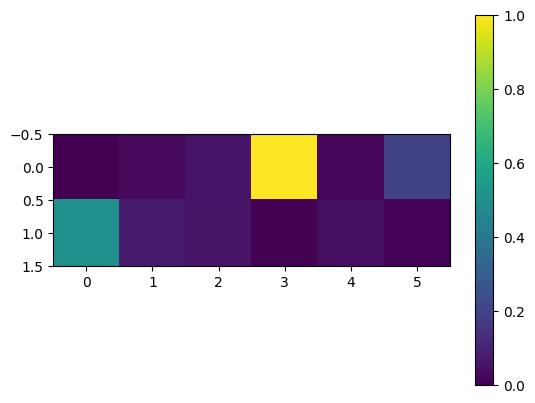

In [10]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

def wrapped_model(x):
    column_names = [f'column_{i}' for i in range(12)]
    x = pd.DataFrame(x)
    x.columns = column_names
    preds = predictor.predict(x).to_numpy()
        
    return preds

test_data = TabularDataset('Test.csv')

to_be_explained = pd.DataFrame(test_data).drop('label', axis=1).to_numpy()[0]
explainer = shap.KernelExplainer(wrapped_model, pd.read_csv('./Train.csv').drop('label', axis=1).sample(n=100))
shap_values = explainer.shap_values(to_be_explained)
relevance = abs(shap_values.ravel())


norm_relevance = ((relevance - min(relevance)) / (max(relevance) - min(relevance)))

print(relevance)
plt.imshow(norm_relevance.reshape((2, 6)))
plt.colorbar()

Intercept 0.6048015107710185
Prediction_local [0.16731967]
Right: 0.004854635801166296
[0.01284813 0.09808043 0.02995154 0.1029113  0.01256941 0.27437583
 0.06893565 0.00233376 0.02109475 0.15272804 0.00549973 0.00543167]


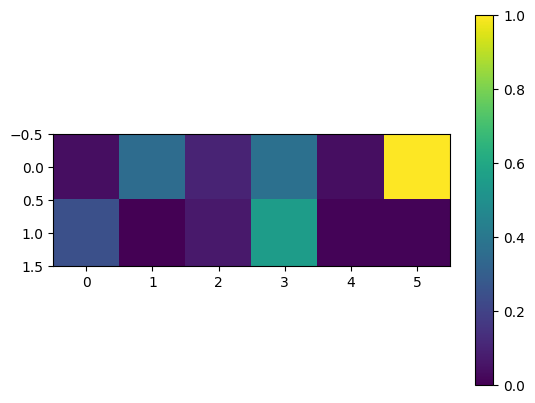

In [9]:
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def wrapped_net(x):
    column_names = [f'column_{i}' for i in range(12)]
    x = pd.DataFrame(x)
    x.columns = column_names
    preds = predictor.predict_proba(x).to_numpy()
        
    return preds

background = pd.read_csv('./Train.csv').drop('label', axis=1).sample(n=100).to_numpy()
explainer = lime.lime_tabular.LimeTabularExplainer(
    background,
    feature_names=[str(i) for i in range(12)],
    verbose=True,
    mode='classification',
)

test = pd.read_csv('./Train.csv').drop('label', axis=1).to_numpy()[0]

exp = explainer.explain_instance(test, wrapped_net, num_features=12)
# exp.save_to_file('lime_explanationall.html')
# relevance = abs(np.asarray([float(i) for i in exp.domain_mapper.feature_values]))
relevance = abs(np.asarray([j for i, j in sorted(exp.local_exp[1], key=lambda i: i[0])]))


perc_relevance = 100 * relevance / sum(relevance)
# relevance = exp.local_exp[1]
norm_relevance = ((relevance - min(relevance)) / (max(relevance) - min(relevance)))


print(relevance)
plt.imshow(norm_relevance.reshape((2, 6)))
plt.colorbar()